In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

## Anderson acceleration 

In [2]:
def anderson_acc(X, *args, **kwargs):
    k = 5
    if len(X) < k + 2:
        return X[-1]
    X = np.array(X[-(k + 1):]).T
    R = (X[:, 1:] - X[:, :-1])
    z = np.linalg.solve(R.T @ R, np.ones(R.shape[1]))
    c = z / z.sum()
    return X[:, :-1] @ c

## Adaptive Regularized Nonlinear Acceleration

In [3]:
def ARNA(X, f, lmin=0.1, lmax=10 ** 4):
    k = 5
    if len(X) < k + 2:
        return X[-1]

    ls = np.exp(np.linspace(np.log(lmin), np.log(lmax), k))

    X = np.array(X[-(k + 2):]).T
    R = (X[:, 1:] - X[:, :-1])
    M = R.T @ R
    M = M / np.linalg.norm(M)

    x_extr = []
    for lambd in ls:
        try:
            z = np.linalg.solve(M + lambd, np.ones(R.shape[1]))
        except:
            continue
        c = z / z.sum()
        x_extr.append(X[:, :-1] @ c)

    if len(x_extr) == 0:
        raise Exception()

    fs = np.array([f(x) for x in x_extr])
    x_opt = x_extr[fs.argmin()]

    x0 = X[:, -(k + 1)]

    def F(t):
        return f(x0 + t * (x_opt - x0))

    t = 1
    while F(2 * t) < F(t):
        t *= 2

    return x0 + t * (x_opt - x0)

# Примеры использования 

## Сходимость аналогична методу Нестерова

Сгенерируем плохо обусловленную задачу

Condition number = 1000.0000000003622


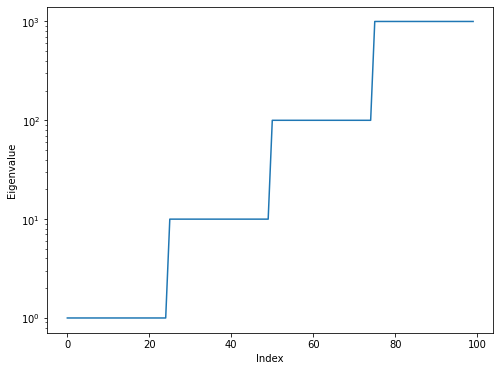

In [4]:
n = 100
A = np.diagflat([np.ones(n//4), 10 * np.ones(n//4), 100*np.ones(n//4), 1000* np.ones(n//4)])
U = np.random.rand(n, n)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5
b = np.random.randn(n)
eig_vals = np.linalg.eigvalsh(A)
print("Condition number = {}".format(max(eig_vals) / min(eig_vals)))
plt.figure(figsize=(8,6))
plt.semilogy(np.sort(eig_vals))
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.show()

In [5]:
f1 = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f1 = lambda x: A.dot(x) - b
x01 = np.zeros(n)

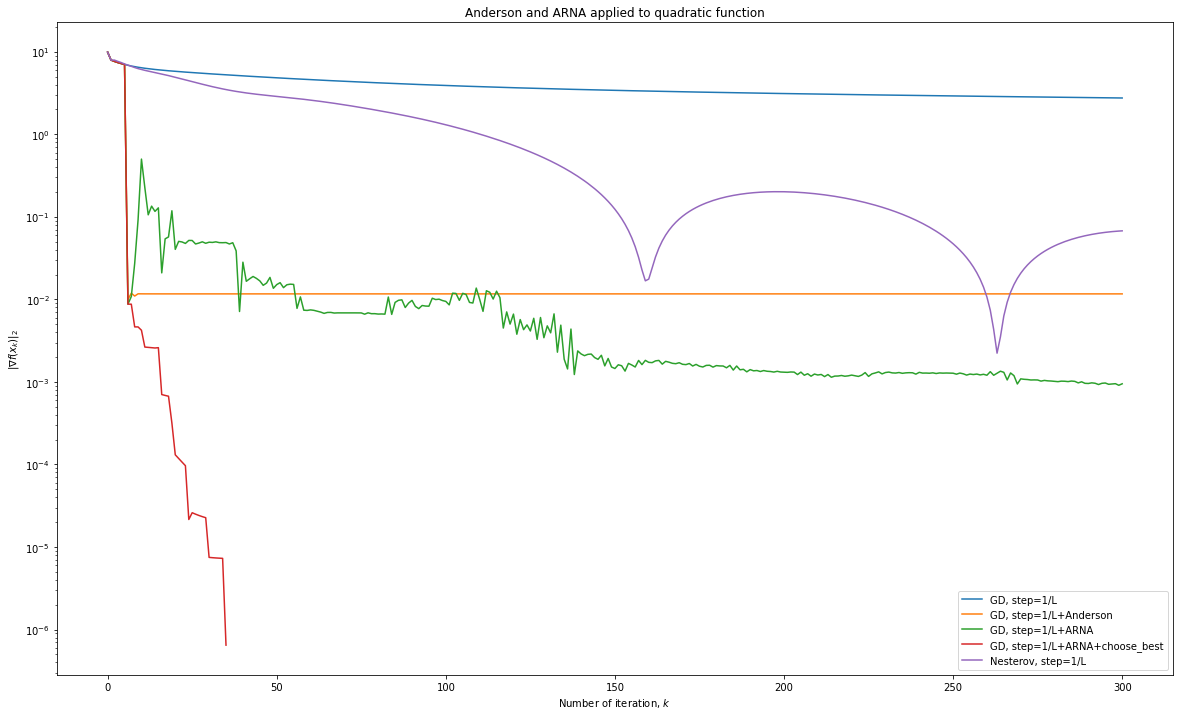

In [7]:
from liboptpy_acc import unconstr_solvers as solvers
from liboptpy_acc import step_size as ss

vals = np.linalg.eigvalsh(A)
opt_step = 1 / vals.max()

m_dict = {
    "GD, step=1/L": solvers.fo.GradientDescent(f1, grad_f1, ss.ConstantStepSize(opt_step)),
    "GD, step=1/L+Anderson": solvers.fo.GradientDescent(f1, grad_f1, ss.ConstantStepSize(opt_step),
    accelerator=anderson_acc),
    "GD, step=1/L+ARNA": solvers.fo.GradientDescent(f1, grad_f1, ss.ConstantStepSize(opt_step), accelerator=ARNA),
    "GD, step=1/L+ARNA+choose_best": solvers.fo.GradientDescent(f1, grad_f1, ss.ConstantStepSize(opt_step),
                                                                accelerator=ARNA, choose_best=True),
    "Nesterov, step=1/L": solvers.fo.AcceleratedGD(f1, grad_f1, ss.ConstantStepSize(opt_step))
}

tol = 10 ** -6
max_iter = 300
for key in m_dict:
    _ = m_dict[key].solve(x01, max_iter, tol)

plt.figure(figsize=(20, 12))
plt.title('Anderson and ARNA applied to quadratic function')
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f1(x)) for x in m_dict[key].get_convergence()], label=key)
    plt.xlabel("Number of iteration, $k$")
plt.ylabel(r"$\| \nabla f(x_k)\|_2$")
plt.legend()
plt.show()